In [21]:
!pip install medpy

In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import h5py
import os 
from scipy.ndimage import zoom, rotate
import random 
# torch 
import torch 
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
from torch.utils.data import Sampler
import torch.optim as optim 
import sys

import itertools
import torchvision.transforms as transforms 
import torch.nn as nn 
import torch.nn.functional as F 
from medpy import metric 
from skimage.measure import label 
import logging
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from torch.nn import CrossEntropyLoss
from tensorboardX import SummaryWriter

#### 1. ACDC Dataset

In [23]:
class BaseDataset(Dataset): 
    def __init__(self, root_path, split= 'train', transform= None, num= None): 
        """
        Use to load name of file.list 

        """
        self.root_path = root_path
        self.split = split 
        self.transform = transform
        self.sample_list = []

        if split == 'train': 
            file_name = os.path.join(self.root_path, 'train_slices.list')
            with open(file_name, 'r') as file: 
                self.sample_list = file.readlines() 
            
            self.sample_list = [item.replace('\n', '') for item in self.sample_list]
            # print(self.sample_list)
        elif split == 'val': 
            file_name = os.path.join(self.root_path, 'val.list')
            with open(file_name, 'r') as file: 
                self.sample_list = file.readlines() 
            
            self.sample_list = [item.replace('\n','') for item in self.sample_list]
            # print(self.sample_list)
        
        else: 
            raise ValueError(f'Mode: {self.split} is not supported')
        

        if isinstance(num, int): 
            self.sample_list = self.sample_list[:num]
        
        print(f'Total slices: {len(self.sample_list)}')
        

    def __len__(self): 
        return len(self.sample_list)

    def __getitem__(self, index):
        case = self.sample_list[index]

        # open the file.h5 
        if self.split == 'train': 
            file_path = os.path.join(self.root_path, f'data/slices/{case}.h5')
        elif self.split == 'val': 
            file_path = os.path.join(self.root_path, f'data/{case}.h5')
        
        h5f = h5py.File(file_path, 'r')
        image = h5f['image'][:]
        label = h5f['label'][:]

        sample = {'image': image, 'label': label}
        if self.split == 'train' and self.transform is not None: 
            sample = self.transform(sample)
        
        sample['case'] = case 
        return sample 

In [24]:
def random_rot_flip(image, label): 
    """
    Random rotate and Random flip 
    """
    
    # Random rotate
    k = np.random.randint(0, 4) 
    image = np.rot90(image, k)
    label = np.rot90(label, k)

    # Random flip 
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis).copy() 
    label = np.flip(label, axis).copy() 

    return image, label 

def random_rotate(image, label):
    angle = np.random.randint(-20, 20) 
    image = rotate(image, angle, order= 0, reshape= False)
    label = rotate(label,angle, order=0, reshape= False )
    return image, label

class RandomGenerator: 
    def __init__(self, output_size): 
        self.output_size = output_size
    
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        if np.random.random() > 0.5: 
            image, label = random_rot_flip(image, label)
        
        if np.random.random() > 0.5: 
            image, label = random_rotate(image, label) 
        
        # Zoom image to -> [256,256]
        x,y = image.shape
        image = zoom(image, (self.output_size[0] / x, self.output_size[1] / y), order= 0)
        label = zoom(label, (self.output_size[0] /x , self.output_size[1] / y), order= 0)

        # Convert to pytorch 
        imageTensor = torch.from_numpy(image.astype(np.float32)).unsqueeze(0) # image.shape = (1, H, W)
        labelTensor = torch.from_numpy(label.astype(np.uint8)) # label.shape = (H, W)
        sample = {'image': imageTensor, 'label': labelTensor}
        
        return sample
    

In [25]:
def iterate_once(indices): 
    """
    Permutate the iterable once 
    (permutate the labeled_idxs once)
    """
    return np.random.permutation(indices) 

def iterate_externally(indices): 
    """
    Create an infinite iterator that repeatedly permutes the indices.
    ( permutate the unlabeled_idxs to make different)
    """
    def infinite_shuffles(): 
        while True: 
            yield np.random.permutation(indices)
            
    return itertools.chain.from_iterable(infinite_shuffles())

def grouper(iterable, n): 
    args = [iter(iterable)] * n 
    return zip(*args)

class TwoStreamBatchSampler(Sampler): 
    def __init__(self, primary_indicies, secondary_indicies, batchsize, secondary_batchsize): 
        self.primary_indicies = primary_indicies
        self.secondary_indicies = secondary_indicies
        self.primary_batchsize = batchsize - secondary_batchsize
        self.secondary_batchsize = secondary_batchsize

        assert len(self.primary_indicies) >= self.primary_batchsize > 0 
        assert len(self.secondary_indicies) >= self.secondary_batchsize > 0 

    def __iter__(self):
        primary_iter = iterate_once(self.primary_indicies)
        secondary_iter = iterate_externally(self.secondary_indicies)

        return (
            primary_batch + secondary_batch
            for (primary_batch, secondary_batch) 
            in zip(grouper(primary_iter, self.primary_batchsize),
                   grouper(secondary_iter, self.secondary_batchsize))
        )

    def __len__(self): 
        return len(self.primary_indicies) // self.primary_batchsize

In [26]:
# Split the data 
def patients_to_slices(dataset, patients_num): 
    ref_dict = {} 
    if "ACDC" in dataset: 
        ref_dict = {'1': 32, '3': 68, '7': 136, '14': 256, '21': 396, '28': 512, '35': 664, '70': 1312}
    else:
        print('Error')
    
    return ref_dict[str(patients_num)]

#### 2. Loss 

In [27]:
class DiceLoss(nn.Module): 
    def __init__(self, n_classes): 
        super(DiceLoss, self).__init__() 
        self.n_classes = n_classes
    
    def _one_hot_encoder(self, input_tensor): # torch.nn.functional.one_hot()
        """
        Apply one-hot encoder for input_tensor 
        Parameters: 
            - input_tensor.shape = (batchsize,1, H, W), the target image
        """
        tensor_list = [] 
        for i in range(self.n_classes): 
            temp_prob = input_tensor == i * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob)
        output_tensor = torch.cat(tensor_list, dim= 1)
        return output_tensor.float() 
    
    def _dice_loss(self, score, target): 
        target = target.float() 
        smooth = 1e-10 
        
        intersection = torch.sum(score * target)
        union = torch.sum(score* score) + torch.sum(target*target)
        dice = ( 2*intersection + smooth) / (union + smooth)
        loss = 1 - dice 
        return loss 
    
    def _dice_mask_loss(self, score, target, mask): 
        target = target.float() 
        mask = mask.float() 
        smooth = 1e-10 

        intersection = torch.sum(score * target * mask)
        union = torch.sum(score * score * mask ) + torch.sum(target * target * mask)
        dice = (2*intersection + smooth) / (union + smooth)
        loss = 1 - dice 
        return loss 

    def forward(self, inputs, target, mask= None, weight= None, softmax= False): 
        if softmax: 
            inputs = torch.softmax(inputs, dim= 1) 
        
        target = self._one_hot_encoder(target)

        # weight 
        if weight is  None: 
            weight = [1] * self.n_classes
        
        assert inputs.size() == target.size(), 'predict and target shape do not match'
        class_wise_dice = [] 
        loss = 0.0 
        if mask is not None: 
            mask = mask.repeat(1, self.n_classes, 1, 1).type(torch.float32)
            for i in range(0, self.n_classes): 
                dice = self._dice_mask_loss(inputs[:, i], target[:, i], mask[:, i])
                class_wise_dice.append( 1.0 - dice.item())
                loss += dice * weight[i]

        else: 
            for i in range(0, self.n_classes): 
                dice = self._dice_loss(inputs[:, i], target[:, i]) 
                class_wise_dice.append(1.0 - dice.item())
                loss += dice * weight[i] 
        
        return loss / self.n_classes

In [28]:
dice_loss = DiceLoss(n_classes= 4)

In [29]:
def mix_loss(output, img_l, patch_l, mask, l_weight=1.0, u_weight=0.5, unlab=False):
    CE = nn.CrossEntropyLoss(reduction='none')
    img_l, patch_l = img_l.type(torch.int64), patch_l.type(torch.int64)
    output_soft = F.softmax(output, dim=1)
    image_weight, patch_weight = l_weight, u_weight
    if unlab:
        image_weight, patch_weight = u_weight, l_weight
    patch_mask = 1 - mask
    loss_dice = dice_loss(output_soft, img_l.unsqueeze(1), mask.unsqueeze(1)) * image_weight
    loss_dice += dice_loss(output_soft, patch_l.unsqueeze(1), patch_mask.unsqueeze(1)) * patch_weight
    loss_ce = image_weight * (CE(output, img_l) * mask).sum() / (mask.sum() + 1e-16) 
    loss_ce += patch_weight * (CE(output, patch_l) * patch_mask).sum() / (patch_mask.sum() + 1e-16)#loss = loss_ce
    return loss_dice, loss_ce

#### 3.Valid 


In [30]:
def calculate_metric_percase(pred, gt):
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    if pred.sum() > 0:
        dice = metric.binary.dc(pred, gt)
        hd95 = metric.binary.hd95(pred, gt)
        return dice, hd95
    else:
        return 0, 0


def test_single_volume(image, label, model, classes, patch_size=[256, 256]):
    image, label = image.squeeze(0).cpu().detach().numpy(), label.squeeze(0).cpu().detach().numpy()
    prediction = np.zeros_like(label)
    for ind in range(image.shape[0]):
        slice = image[ind, :, :]
        x, y = slice.shape[0], slice.shape[1]
        slice = zoom(slice, (patch_size[0] / x, patch_size[1] / y), order=0)
        input = torch.from_numpy(slice).unsqueeze(0).unsqueeze(0).float().cuda()
        model.eval()
        with torch.no_grad():
            output = model(input)
            if len(output)>1:
                output = output[0]
            out = torch.argmax(torch.softmax(output, dim=1), dim=1).squeeze(0)
            out = out.cpu().detach().numpy()
            pred = zoom(out, (x / patch_size[0], y / patch_size[1]), order=0)
            prediction[ind] = pred
    metric_list = []
    for i in range(1, classes):
        metric_list.append(calculate_metric_percase(prediction == i, label == i))
    return metric_list


#### 3. UNet

In [ ]:
from __future__ import division, print_function

import numpy as np
import torch
import torch.nn as nn
import pdb
from torch.nn import functional as F
from torch.distributions.uniform import Uniform


class ConvBlock(nn.Module):
    """two convolution layers with batch norm and leaky relu"""
    def __init__(self, in_channels, out_channels, dropout_p):
        super(ConvBlock, self).__init__()
        self.conv_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv_conv(x)

class DownBlock(nn.Module):
    """Downsampling followed by ConvBlock"""
    def __init__(self, in_channels, out_channels, dropout_p):
        super(DownBlock, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels, dropout_p)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class UpBlock(nn.Module):
    """Upsampling followed by ConvBlock"""
    def __init__(self, in_channels1, in_channels2, out_channels, dropout_p):
        super(UpBlock, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels1, in_channels2, kernel_size=1)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = ConvBlock(in_channels2 * 2, out_channels, dropout_p)

    def forward(self, x1, x2):
        x1 = self.conv1x1(x1)
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Encoder(nn.Module):
    def __init__(self, params):
        super(Encoder, self).__init__()
        self.params = params
        self.in_chns = self.params['in_chns']
        self.ft_chns = self.params['feature_chns']
        self.n_class = self.params['class_num']
        self.dropout = self.params['dropout']
        assert (len(self.ft_chns) == 5)
        self.in_conv = ConvBlock(
            self.in_chns, self.ft_chns[0], self.dropout[0])
        self.down1 = DownBlock(
            self.ft_chns[0], self.ft_chns[1], self.dropout[1])
        self.down2 = DownBlock(
            self.ft_chns[1], self.ft_chns[2], self.dropout[2])
        self.down3 = DownBlock(
            self.ft_chns[2], self.ft_chns[3], self.dropout[3])
        self.down4 = DownBlock(
            self.ft_chns[3], self.ft_chns[4], self.dropout[4])

    def forward(self, x):
        x0 = self.in_conv(x)
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        return [x0, x1, x2, x3, x4]

class Decoder(nn.Module):
    def __init__(self, params):
        super(Decoder, self).__init__()
        self.params = params
        self.in_chns = self.params['in_chns']
        self.ft_chns = self.params['feature_chns']
        self.n_class = self.params['class_num']
        assert (len(self.ft_chns) == 5)

        self.up1 = UpBlock(self.ft_chns[4], self.ft_chns[3], self.ft_chns[3], dropout_p=0.0)
        self.up2 = UpBlock(self.ft_chns[3], self.ft_chns[2], self.ft_chns[2], dropout_p=0.0)
        self.up3 = UpBlock(self.ft_chns[2], self.ft_chns[1], self.ft_chns[1], dropout_p=0.0)
        self.up4 = UpBlock(self.ft_chns[1], self.ft_chns[0], self.ft_chns[0], dropout_p=0.0)

        self.out_conv = nn.Conv2d(self.ft_chns[0], self.n_class, kernel_size=3, padding=1)

    def forward(self, feature):
        x0 = feature[0]
        x1 = feature[1]
        x2 = feature[2]
        x3 = feature[3]
        x4 = feature[4]

        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x_last = self.up4(x, x0)
        output = self.out_conv(x_last)
        return output, x_last
    
class UNet_2d(nn.Module):
    def __init__(self, in_chns, class_num):
        super(UNet_2d, self).__init__()

        params = {'in_chns': in_chns,
                  'feature_chns': [16, 32, 64, 128, 256],
                  'dropout': [0.05, 0.1, 0.2, 0.3, 0.5],
                  'class_num': class_num,
                  'acti_func': 'relu'}

        self.encoder = Encoder(params)
        self.decoder = Decoder(params)

    def forward(self, x):
        feature = self.encoder(x)
        output, features = self.decoder(feature)
        return output

In [32]:
def BCP_net(in_chns=1, class_num=4, ema=False):
    net = UNet_2d(in_chns=in_chns, class_num=class_num).cuda()
    if ema:
        for param in net.parameters():
            param.detach_()
    return net


#### 4.Training 

In [33]:
def get_ACDC_2DLargestCC(segmentation):
    batch_list = []
    N = segmentation.shape[0]
    for i in range(0, N):
        class_list = []
        for c in range(1, 4):
            temp_seg = segmentation[i] #== c *  torch.ones_like(segmentation[i])
            temp_prob = torch.zeros_like(temp_seg)
            temp_prob[temp_seg == c] = 1
            temp_prob = temp_prob.detach().cpu().numpy()
            labels = label(temp_prob)          
            if labels.max() != 0:
                largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
                class_list.append(largestCC * c)
            else:
                class_list.append(temp_prob)
        
        n_batch = class_list[0] + class_list[1] + class_list[2]
        batch_list.append(n_batch)

    return torch.Tensor(batch_list).cuda()
    
def get_ACDC_masks(output, nms=0):
    probs = F.softmax(output, dim=1)
    _, probs = torch.max(probs, dim=1)
    if nms == 1:
        probs = get_ACDC_2DLargestCC(probs)      
    return probs

In [34]:
def save_net_opt(net, optimizer, path):
    state = {
        'net': net.state_dict(),
        'optim': optimizer.state_dict()
    }
    torch.save(state, str(path))

def load_net(net, path):
    state = torch.load(str(path))
    net.load_state_dict(state['net']) 

def load_net_opt(net, optimizer, path): 
    state = torch.load(str(path))
    net.load_state_dict(state['net'])
    optimizer.load_state_dict(state['optim'])

In [35]:
def generate_mask(img):
    batch_size, channel, img_x, img_y = img.shape[0], img.shape[1], img.shape[2], img.shape[3]
    loss_mask = torch.ones(batch_size, img_x, img_y).cuda()
    mask = torch.ones(img_x, img_y).cuda()
    patch_x, patch_y = int(img_x*2/3), int(img_y*2/3)
    w = np.random.randint(0, img_x - patch_x)
    h = np.random.randint(0, img_y - patch_y)
    mask[w:w+patch_x, h:h+patch_y] = 0
    loss_mask[:, w:w+patch_x, h:h+patch_y] = 0
    return mask.long(), loss_mask.long()

In [36]:
def sigmoid_rampup(current, rampup_length):
    if rampup_length == 0: 
        return 1.0 
    else:
        current = np.clip(current, 0, rampup_length)
        phase = 1 - (current / rampup_length)
        return float(np.exp(-5 * phase * phase))

In [37]:
# Mean-Teacher compomnent 
def get_current_consistency_weight(epoch, args): 
    return 5 * args.consistency + sigmoid_rampup(epoch, args.consistency_rampup)

def update_model_ema(model, ema_model, alpha): 
    model_state = model.state_dict() 
    model_ema_state = ema_model.state_dict()

    new_dict = {} 

    for key in model_state:
        new_dict[key] = alpha * model_ema_state[key] + (1 - alpha) * model_state[key]

    ema_model.load_state_dict(new_dict)

def compute_weight_distance(teacher_model, student_model): 
    total_distance = 0.0 
    for (t_param, s_param) in zip(teacher_model.parameters(), student_model.parameters()): 
        total_distance += torch.norm(t_param.data - s_param.data, 2).item()
    
    return total_distance 

In [38]:
# Configuration
def pre_train(args, snapshot_path):
    base_lr = args.base_lr
    num_classes = args.num_classes
    max_iterations = args.pretrain_iterations
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu 
    pre_trained_model = os.path.join(snapshot_path, '{}_best_model.pth'.format(args.model))
    labeled_sub_bs, unlabeled_sub_bs = int(args.labeled_bs / 2), int((args.batch_size - args.labeled_bs)/2)

    def worker_init_fn(worker_id):
        random.seed(args.seed + worker_id)

    # load dataset 
    db_train = BaseDataset(root_path = args.root_dir, split= 'train', 
                        num= None, 
                        transform= transforms.Compose([RandomGenerator(args.patch_size)]))
    
    db_val = BaseDataset(root_path= args.root_dir, split= 'val')

    total_slices = len(db_train)
    labeled_slices = patients_to_slices(args.root_dir, args.label_num)
    print(f'Total slice is {total_slices}, Labeled slice is {labeled_slices}')

    # Create batch_sampler 
    labeled_idxs = list(range(0, labeled_slices))
    unlabeled_idxs = list(range(labeled_slices, total_slices))
    batch_sampler = TwoStreamBatchSampler(labeled_idxs, unlabeled_idxs, args.batch_size, args.batch_size - args.labeled_bs)

    # Create dataloader 
    trainloader = DataLoader(db_train, batch_sampler= batch_sampler, num_workers= 4, pin_memory= True, worker_init_fn= worker_init_fn)
    valloader = DataLoader(db_val, batch_size= 1, shuffle= False, num_workers=1)

    # Define model 
    model = BCP_net(in_chns=1, class_num= num_classes)
    optimizer = optim.SGD(model.parameters(), lr= base_lr, momentum= 0.9, weight_decay= 0.0001)

    writer = SummaryWriter(snapshot_path + '/log')

    # training process
    model.train() 
    iter_num = 0 
    max_epoch = max_iterations // len(trainloader) + 1 
    best_performance = 0.0 
    best_hd = 100.0
    iterator = tqdm(range(max_epoch), ncols= 70)
    
    for _ in iterator: 
        for _, sampled_batch in enumerate(trainloader): 
            volume_batch, label_batch = sampled_batch['image'], sampled_batch['label']
            volume_batch, label_batch = volume_batch.cuda(), label_batch.cuda() 

            img_a, img_b = volume_batch[: labeled_sub_bs], volume_batch[labeled_sub_bs : args.labeled_bs]
            lab_a, lab_b = label_batch[: labeled_sub_bs], label_batch[labeled_sub_bs : args.labeled_bs]
            img_mask, loss_mask = generate_mask(img_a)
            gt_mixl = lab_a * img_mask + lab_b * ( 1- img_mask)

            #-- original 
            net_input = img_a * img_mask + img_b * ( 1 - img_mask)  
            out_mixl = model(net_input)
            loss_dice, loss_ce = mix_loss(out_mixl, lab_a, lab_b, loss_mask,u_weight= 1.0, unlab= True )
            loss = (loss_dice + loss_ce )/2 

            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 

            iter_num += 1 

            writer.add_scalar('info/total_loss', loss, iter_num)
            writer.add_scalar('info/mix_dice', loss_dice,iter_num )
            writer.add_scalar('info/mix_ce', loss_ce, iter_num)

            if iter_num % 20 == 0: 
                image = net_input[1, 0:1, :, :]
                writer.add_image('pre_train/Mixed_Image', image, iter_num)
                outputs = torch.argmax(torch.softmax(out_mixl, dim=1), dim=1, keepdim= True)
                writer.add_image('pre_train/Mixed_Prediction', outputs[1, ...]*50, iter_num)
                labs = gt_mixl[1, ...].unsqueeze(0) * 50 
                writer.add_image('pre_train/Mixed_GroundTruth', labs, iter_num)
            
            # Evaluate after 200 epoch ! 
            if iter_num > 0 and iter_num % 200 == 0: 
                model.eval() 
                metric_list = 0.0 
                for _, sampled_batch in enumerate(valloader):
                    metric_i = test_single_volume(sampled_batch['image'], sampled_batch['label'], model, classes= num_classes)
                    metric_list += np.array(metric_i)
                
                metric_list = metric_list / len(db_val)
                
    
                for class_i in range(num_classes - 1 ): 
                    writer.add_scalar('info/val_{}_dice'.format(class_i + 1), metric_list[class_i, 0], iter_num)
                    writer.add_scalar('infor/val_{}_hd'.format(class_i + 1), metric_list[class_i, 1], iter_num)
                
                performance = np.mean(metric_list, axis=0)[0]
                writer.add_scalar('info/val_mean_dice', performance, iter_num)
            
                if performance > best_performance: 
                    best_performance = performance
                    save_model_path = os.path.join(snapshot_path, 'iter_{}_dice_{}.pth'.format(iter_num, round(best_performance,4)))
                    save_best_path = os.path.join(snapshot_path, '{}_best_model.pth'.format(args.model))
                    save_net_opt(model, optimizer, save_model_path)
                    save_net_opt(model, optimizer, save_best_path)
                
                model.train() 
            
            if iter_num >= max_iterations: 
                break 
        
        if iter_num >= max_iterations: 
            iterator.close() 
            break 
    
    writer.close()

In [39]:
def self_train(args ,pre_snapshot_path, snapshot_path):
    # Check coupling 
    distances = [] 

    base_lr = args.base_lr
    num_classes = args.num_classes
    max_iterations = args.selftrain_iterations
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    pre_trained_model = os.path.join(pre_snapshot_path,'{}_best_model.pth'.format(args.model))
    labeled_sub_bs, unlabeled_sub_bs = int(args.labeled_bs/2), int((args.batch_size-args.labeled_bs) / 2)
     
    model = BCP_net(in_chns=1, class_num=num_classes)
    ema_model = BCP_net(in_chns=1, class_num=num_classes, ema=True)

    def worker_init_fn(worker_id):
        random.seed(args.seed + worker_id)

    db_train = BaseDataset(root_path=args.root_dir,
                            split="train",
                            num=None,
                            transform=transforms.Compose([RandomGenerator(args.patch_size)]))
    db_val = BaseDataset(root_path=args.root_dir, split="val")
    total_slices = len(db_train)
    labeled_slice = patients_to_slices(args.root_dir,args.label_num)
    print("Total slices is: {}, labeled slices is:{}".format(total_slices, labeled_slice))
    labeled_idxs = list(range(0, labeled_slice))
    unlabeled_idxs = list(range(labeled_slice, total_slices))
    batch_sampler = TwoStreamBatchSampler(labeled_idxs, unlabeled_idxs, args.batch_size, args.batch_size-args.labeled_bs)

    trainloader = DataLoader(db_train, batch_sampler=batch_sampler, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

    valloader = DataLoader(db_val, batch_size=1, shuffle=False, num_workers=1)

    optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0001)
    load_net(ema_model, pre_trained_model)
    load_net_opt(model, optimizer, pre_trained_model) #
    

    writer = SummaryWriter(snapshot_path + '/log')

    model.train()
    ema_model.train()

    ce_loss = CrossEntropyLoss()

    iter_num = 0
    max_epoch = max_iterations // len(trainloader) + 1
    best_performance = 0.0
    best_hd = 100
    iterator = tqdm(range(max_epoch), ncols=70)
    for _ in iterator:
        for _, sampled_batch in enumerate(trainloader):
            
            volume_batch, label_batch = sampled_batch['image'], sampled_batch['label']
            volume_batch, label_batch = volume_batch.cuda(), label_batch.cuda()

            img_a, img_b = volume_batch[:labeled_sub_bs], volume_batch[labeled_sub_bs:args.labeled_bs]
            uimg_a, uimg_b = volume_batch[args.labeled_bs:args.labeled_bs + unlabeled_sub_bs], volume_batch[args.labeled_bs + unlabeled_sub_bs:]
            ulab_a, ulab_b = label_batch[args.labeled_bs:args.labeled_bs + unlabeled_sub_bs], label_batch[args.labeled_bs + unlabeled_sub_bs:]
            lab_a, lab_b = label_batch[:labeled_sub_bs], label_batch[labeled_sub_bs:args.labeled_bs]
            with torch.no_grad():
                pre_a = ema_model(uimg_a) # pseudo label a 
                pre_b = ema_model(uimg_b) # pseudo label b 
                plab_a = get_ACDC_masks(pre_a, nms=1)
                plab_b = get_ACDC_masks(pre_b, nms=1)
                img_mask, loss_mask = generate_mask(img_a)
                unl_label = ulab_a * img_mask + lab_a * (1 - img_mask)
                l_label = lab_b * img_mask + ulab_b * (1 - img_mask)
            consistency_weight = get_current_consistency_weight(iter_num//150,args)

            net_input_unl = uimg_a * img_mask + img_a * (1 - img_mask)
            net_input_l = img_b * img_mask + uimg_b * (1 - img_mask)
            out_unl = model(net_input_unl)
            out_l = model(net_input_l)
            unl_dice, unl_ce = mix_loss(out_unl, plab_a, lab_a, loss_mask, u_weight=args.u_weight, unlab=True)
            l_dice, l_ce = mix_loss(out_l, lab_b, plab_b, loss_mask, u_weight=args.u_weight)


            loss_ce = unl_ce + l_ce 
            loss_dice = unl_dice + l_dice

            loss = (loss_dice + loss_ce) / 2            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            iter_num += 1
            update_model_ema(model, ema_model, 0.99)
            weight_distace = compute_weight_distance(ema_model, model) 
            distances.append(weight_distace)

            writer.add_scalar('info/total_loss', loss, iter_num)
            writer.add_scalar('info/mix_dice', loss_dice, iter_num)
            writer.add_scalar('info/mix_ce', loss_ce, iter_num)
            writer.add_scalar('info/consistency_weight', consistency_weight, iter_num)   
            writer.add_scalar('info/weight_distance', weight_distace, iter_num)  
                
            if iter_num % 20 == 0:
                image = net_input_unl[1, 0:1, :, :]
                writer.add_image('train/Un_Image', image, iter_num)
                outputs = torch.argmax(torch.softmax(out_unl, dim=1), dim=1, keepdim=True)
                writer.add_image('train/Un_Prediction', outputs[1, ...] * 50, iter_num)
                labs = unl_label[1, ...].unsqueeze(0) * 50
                writer.add_image('train/Un_GroundTruth', labs, iter_num)

                image_l = net_input_l[1, 0:1, :, :]
                writer.add_image('train/L_Image', image_l, iter_num)
                outputs_l = torch.argmax(torch.softmax(out_l, dim=1), dim=1, keepdim=True)
                writer.add_image('train/L_Prediction', outputs_l[1, ...] * 50, iter_num)
                labs_l = l_label[1, ...].unsqueeze(0) * 50
                writer.add_image('train/L_GroundTruth', labs_l, iter_num)

            if iter_num > 0 and iter_num % 200 == 0:
                model.eval()
                metric_list = 0.0
                for _, sampled_batch in enumerate(valloader):
                    metric_i = test_single_volume(sampled_batch["image"], sampled_batch["label"], model, classes= num_classes)
                    metric_list += np.array(metric_i)
                metric_list = metric_list / len(db_val)
                print(f'Metric list: {metric_list}') 
                for class_i in range(num_classes-1):
                    writer.add_scalar('info/val_{}_dice'.format(class_i+1), metric_list[class_i, 0], iter_num)
                    writer.add_scalar('info/val_{}_hd95'.format(class_i+1), metric_list[class_i, 1], iter_num)

                performance = np.mean(metric_list, axis=0)[0]
                writer.add_scalar('info/val_mean_dice', performance, iter_num)

                if performance > best_performance:
                    best_performance = performance
                    save_mode_path = os.path.join(snapshot_path, 'iter_{}_dice_{}.pth'.format(iter_num, round(best_performance, 4)))
                    save_best_path = os.path.join(snapshot_path,'{}_best_model.pth'.format(args.model))
                    torch.save(model.state_dict(), save_mode_path)
                    torch.save(model.state_dict(), save_best_path)

                model.train()

            if iter_num >= max_iterations:
                break
        if iter_num >= max_iterations:
            iterator.close()
            break
    writer.close()

    # Plot the distance 
    plt.figure(figsize=(15,6))
    plt.plot(range(len(distances)), distances, label='L2 weight distance')
    plt.xlabel('Iterations')
    plt.ylabel('Weight distance (L2)')
    plt.title('Teacher-Student weight distance over iteratations')
    plt.legend()
    plt.grid() 

    # save the image 
    plt.savefig('weight_distance.png', dpi=300)


Pretrain log path: ./model/BCP/ACDC_BCP_7_labeled/pretrain/log.txt
Self-train log path: ./model/BCP/ACDC_BCP_7_labeled/selftrain/log.txt
Total slices: 1312
Total slices: 20
Total slice is 1312, Labeled slice is 136


 97%|████████████████████████████████ | 36/37 [00:42<00:01,  1.17s/it]
/tmp/ipykernel_11604/1417322320.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load

Total slices: 1312
Total slices: 20
Total slices is: 1312, labeled slices is:136


  0%|                                           | 0/1 [00:02<?, ?it/s]


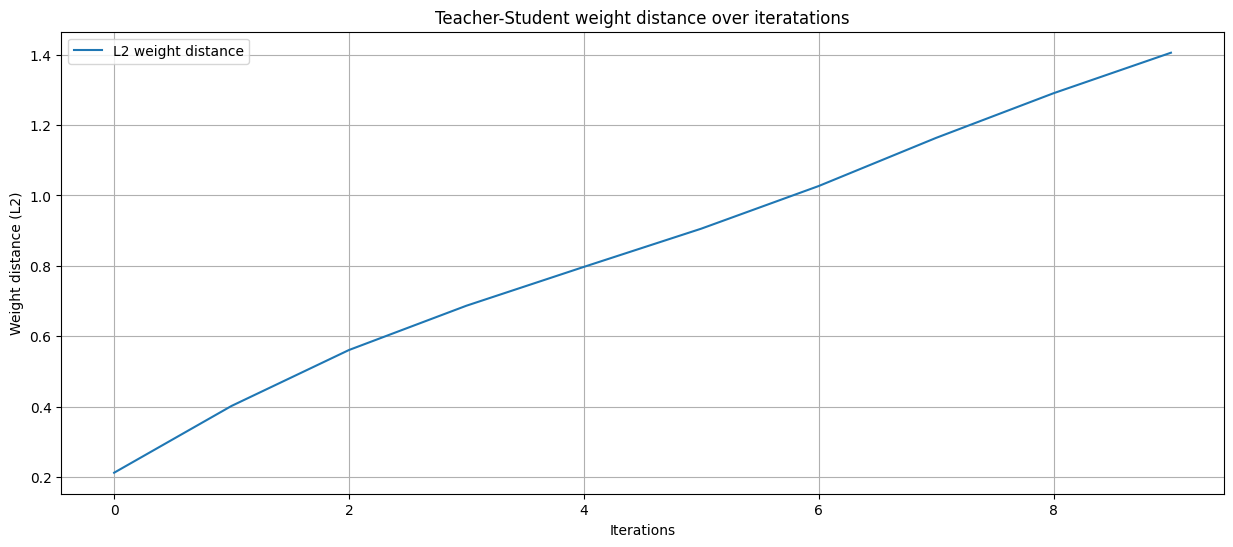

In [40]:
# Params 
class params: 
    def __init__(self): 
        self.root_dir = 'ACDC' 
        self.exp = 'BCP' 
        self.model = 'unet' 
        self.pretrain_iterations = 400 
        
        self.selftrain_iterations = 10 
        self.batch_size = 24
        self.deterministic = 1 # What the fucck here
        self.base_lr = 0.01 
        self.patch_size = [256,256] 
        self.seed = 42 
        self.num_classes = 4 

        # label and unlabel 
        self.labeled_bs = 12
        self.label_num = 7 
        self.u_weight = 0.5 

        # Cost 
        self.gpu = '0' 
        self.consistency = 0.1
        self.consistency_rampup = 200.0 
        self.magnitude = '6.0' 
        self.s_param = 6 


args = params()
# Trainig process 
if args.deterministic: 
    cudnn.benchmark = False 
    cudnn.deterministic = True 
    random.seed(args.seed) 
    np.random.seed(args.seed) 
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)

# Path 
pre_snapshot_path = "./model/BCP/ACDC_{}_{}_labeled/pretrain".format(args.exp, args.label_num)
self_snapshot_path = "./model/BCP/ACDC_{}_{}_labeled/selftrain".format(args.exp, args.label_num)

print(f'Pretrain log path: {pre_snapshot_path + "/log.txt"}')
print(f'Self-train log path: {self_snapshot_path + "/log.txt"}')

for snapshot_path in [pre_snapshot_path, self_snapshot_path]: 
    if not os.path.exists(snapshot_path): 
        os.makedirs(snapshot_path, exist_ok= True)
#Pre_train
logging.basicConfig(filename=pre_snapshot_path+"/log.txt", level=logging.INFO, format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
pre_train(args, pre_snapshot_path)

#Self_train
logging.basicConfig(filename=self_snapshot_path+"/log.txt", level=logging.INFO, format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
self_train(args, pre_snapshot_path, self_snapshot_path)